<a href="https://colab.research.google.com/github/jammy-bot/mask-r-cnn-image-segmentation-transfer-learning/blob/master/mask_r_cnn_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Segmentation Transfer Learning
- Implementing Mask R-CNN Image Segmentation using
pretrained weights from the COCO algorithm.
- Object detection on a custom photograph

__"requirements.txt" files__:
* numpy
* scipy
* Pillow
* cython
* matplotlib
* scikit-image
* tensorflow>=1.3.0
* keras>=2.0.8
* opencv-python
* h5py
* imgaug
*  IPython[all]

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Preliminary Credit Notes:
* Production repo origin: https://github.com/matterport/Mask_RCNN/tree/master/mrcnn
* With code borrowed from this computer vision tutorial: https://www.analyticsvidhya.com/blog/2019/07/computer-vision-implementing-mask-r-cnn-image-segmentation/
* Tensorflow version compatibility suggestion: https://github.com/matterport/Mask_RCNN/issues/1828

In [2]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

In [3]:
!pwd

/content


The matterport `mrcnn` repo has been cloned to a directory of the mounted cloud drive.

In [4]:
!pwd

os.chdir('/content/drive/My Drive/Colab Notebooks/Mask_RCNN')
os.getcwd()

/content


'/content/drive/My Drive/Colab Notebooks/Mask_RCNN'

Set the repository root as `ROOT_DIR`

In [5]:
# project root directory
ROOT_DIR = os.path.abspath("./")

import warnings
warnings.filterwarnings("ignore")

In [6]:
ROOT_DIR

'/content/drive/My Drive/Colab Notebooks/Mask_RCNN'

Install requirements.
> Note:
If deprecation warnings are encountered, it may be necessary to update this file to require the earlier TensorFlow version 1.14.0.

In [7]:
# installing requirements
!pip3 install -r requirements.txt

     |████████████████████████████████| 163kB 3.4MB/s 
     |████████████████████████████████| 204kB 11.1MB/s 


Code still finds Tensorflow 2.2.2 after installing requirements, so we will reinstall it, separately, from pip.

In [8]:
!pip install tensorflow==1.14.0
import tensorflow
print(tensorflow.__version__)

     |████████████████████████████████| 109.2MB 35kB/s 
     |████████████████████████████████| 491kB 28.7MB/s 
     |████████████████████████████████| 3.2MB 51.2MB/s 
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Found existing installation: tensorboard 2.2.2
    Uninstalling tensorboard-2.2.2:
      Successfully uninstalled tensorboard-2.2.2
  Found existing installation: tensorflow 2.2.0
    Uninstalling tensorflow-2.2.0:
      Successfully uninstalled tensorflow-2.2.0
1.14.0


In [9]:
# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

%matplotlib inline

Using TensorFlow backend.


## Define paths for weights and images.

In [10]:
# directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# local path to trained weights file
COCO_MODEL_PATH = os.path.join('', "mask_rcnn_coco.h5")

# downloading COCO trained weights from releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# directory of sample images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

## Set inference class.

In [11]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Create the model and load the weights.

In [12]:
os.getcwd()

'/content/drive/My Drive/Colab Notebooks/Mask_RCNN'

In [13]:
# WARNING replacements
# tf.nn.max_pool = tf.nn.max_pool2d
# tf.log = tf.math.log
# box_ind = box_indices 
# np.where = tf.where
# box_ind = box_indices
# tf.sets.set_intersection = tf.sets.intersection
# tf.sparse_tensor_to_dense = tf.sparse.to_dense
# to_float = tf.cast

In [14]:
# creating model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir='mask_rcnn_coco.hy', config=config)

# loading weights trained on MS-COCO
model.load_weights('mask_rcnn_coco.h5', by_name=True)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


In [15]:
# COCO Class names
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

In [16]:
# using autoreload magic to catch changes to any loaded functions
%load_ext autoreload
%autoreload 2

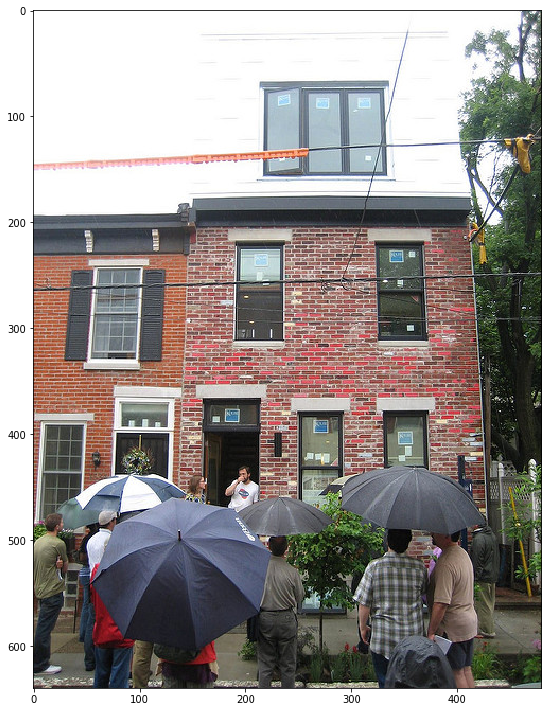

In [17]:
# loading a random image from the images folder
image = skimage.io.imread(
    '/content/drive/My Drive/Colab Notebooks/Mask_RCNN/images/3651581213_f81963d1dd_z.jpg')



# original image
plt.figure(figsize=(12,10))
skimage.io.imshow(image)

Processing 1 images
image                    shape: (640, 480, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32



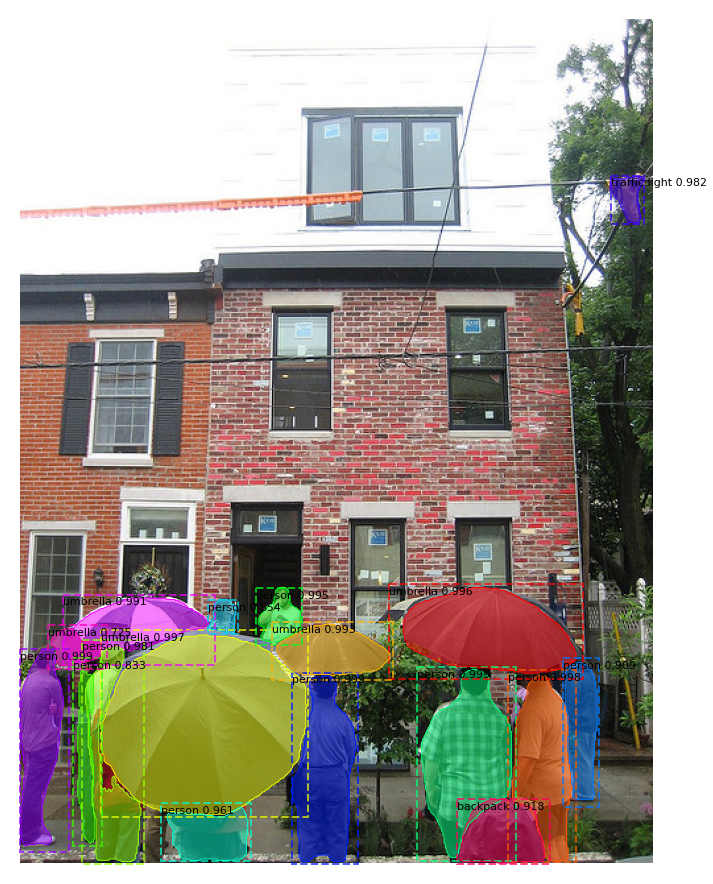

In [18]:
# running detection
results = model.detect([image], verbose=1)

# visualizing results
r = results[0]
visualize.display_instances(image, 
                            r['rois'], 
                            r['masks'], 
                            r['class_ids'], 
                            class_names, 
                            r['scores'])

In [19]:
mask = r['masks']
mask = mask.astype(int)
mask.shape

(640, 480, 17)

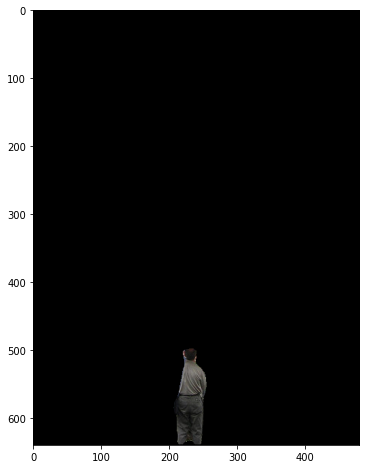

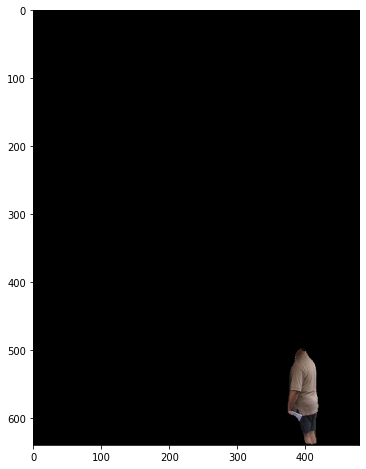

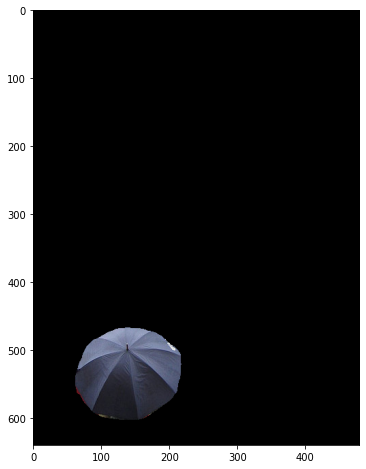

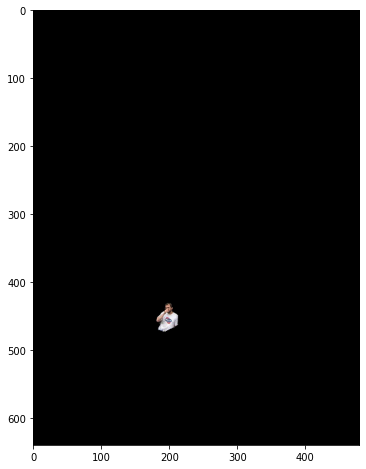

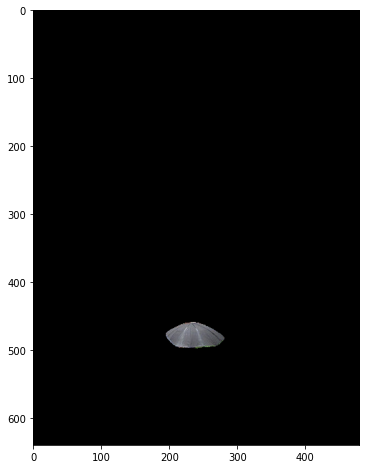

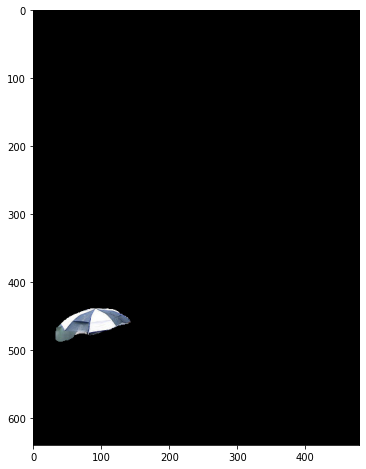

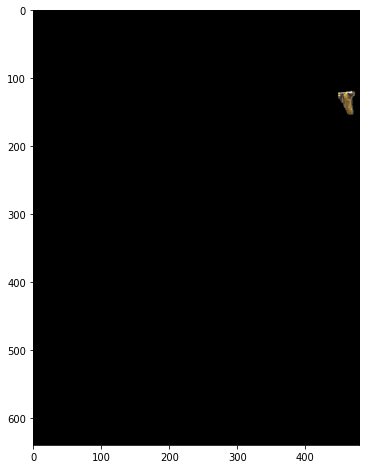

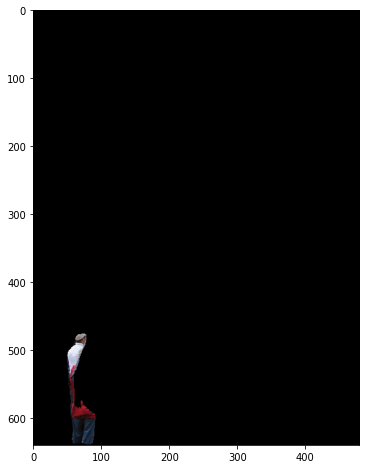

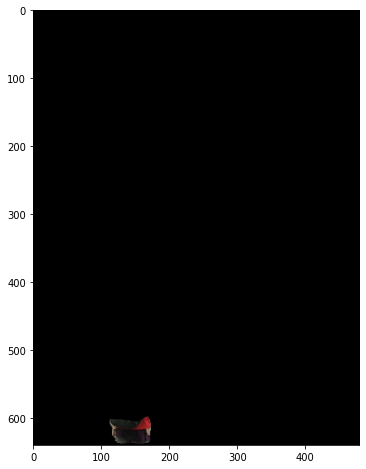

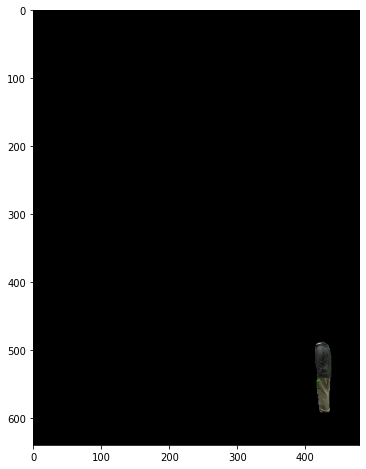

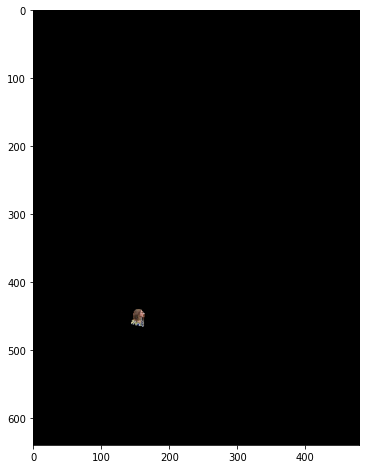

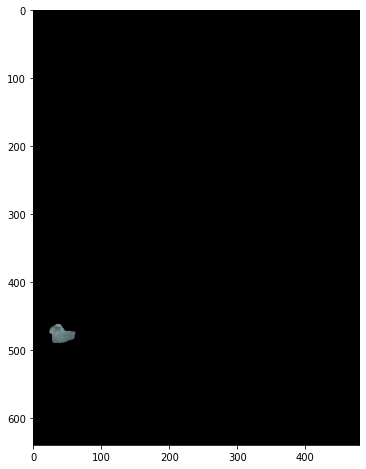

In [20]:
# viewing (inverted) masks for segmented images
for i in range(mask.shape[2]):
    temp = skimage.io.imread(
        '/content/drive/My Drive/Colab Notebooks/Mask_RCNN/images/3651581213_f81963d1dd_z.jpg')
    for j in range(temp.shape[2]):
        temp[:,:,j] = temp[:,:,j] * mask[:,:,i]
    plt.figure(figsize=(8,8))
    plt.imshow(temp)

# Test an image from outside the set.

In [21]:
# loading an image from my images folder
image = skimage.io.imread(
    '/content/drive/My Drive/Colab Notebooks/Mask_RCNN/my_images/IMG_125824_426_640.jpg')
# image = skimage.io.imread(
    # '/content/drive/My Drive/Colab Notebooks/Mask_RCNN/images/4410436637_7b0ca36ee7_z.jpg')

# original image
plt.figure(figsize=(12,10))
skimage.io.imshow(image)

In [22]:
# running detection
results = model.detect([image], verbose=1)

# visualizing results
r = results[0]
visualize.display_instances(image, 
                            r['rois'], 
                            r['masks'], 
                            r['class_ids'], 
                            class_names, 
                            r['scores'])

Processing 1 images
image                    shape: (426, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


In [23]:
mask = r['masks']
mask = mask.astype(int)
mask.shape

(426, 640, 6)

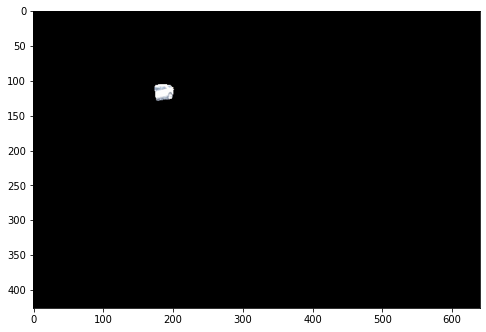

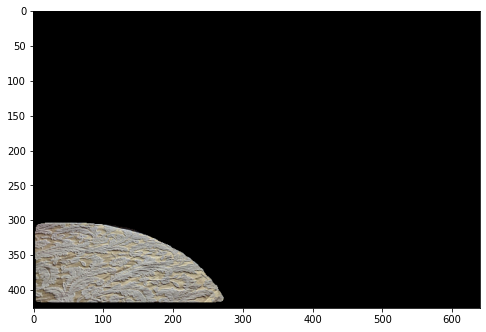

In [24]:
for i in range(mask.shape[2]):
    temp = skimage.io.imread(
        '/content/drive/My Drive/Colab Notebooks/Mask_RCNN/my_images/IMG_125824_426_640.jpg')
    for j in range(temp.shape[2]):
        temp[:,:,j] = temp[:,:,j] * mask[:,:,i]
    plt.figure(figsize=(8,8))
    plt.imshow(temp)

frank-zhang-7q03XfDSKQo-unsplash.jpg

# Test a 2nd image from outside the set.

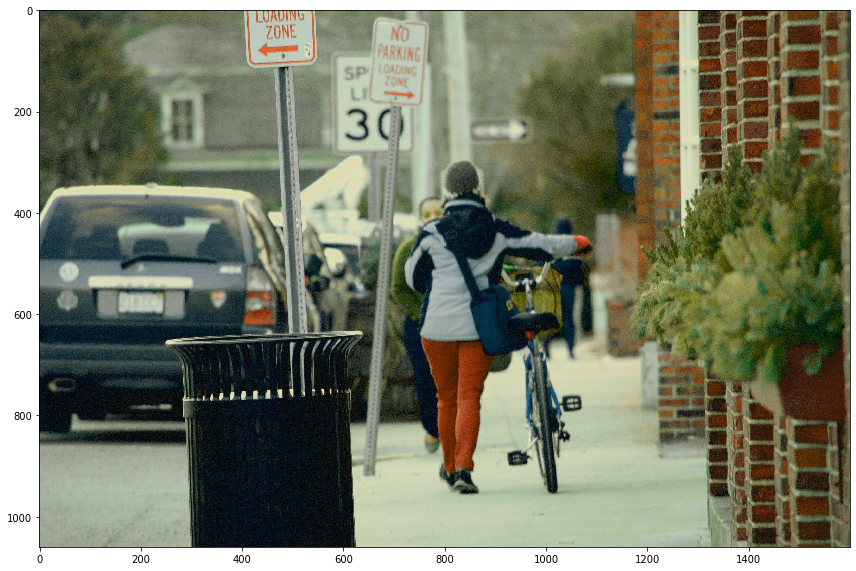

In [25]:
# loading an image from my images folder
image = skimage.io.imread(
    '/content/drive/My Drive/Colab Notebooks/Mask_RCNN/my_images/frank-zhang-7q03XfDSKQo-unsplash.jpg')

# original image
plt.figure(figsize=(12,10))
skimage.io.imshow(image)

In [26]:
# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, 
                            r['rois'], 
                            r['masks'], 
                            r['class_ids'], 
                            class_names, 
                            r['scores'])

Processing 1 images
image                    shape: (1060, 1600, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  130.30000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1600.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


In [27]:
mask = r['masks']
mask = mask.astype(int)
mask.shape

(1060, 1600, 7)

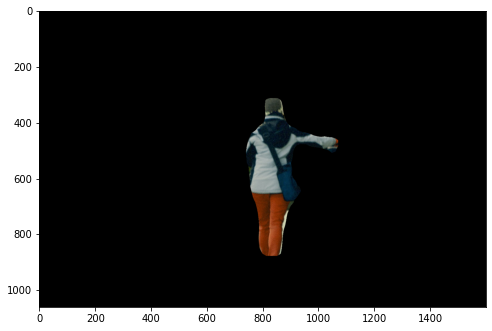

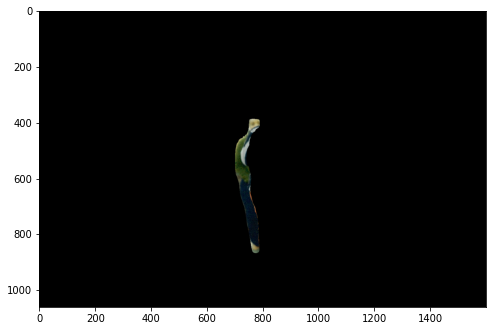

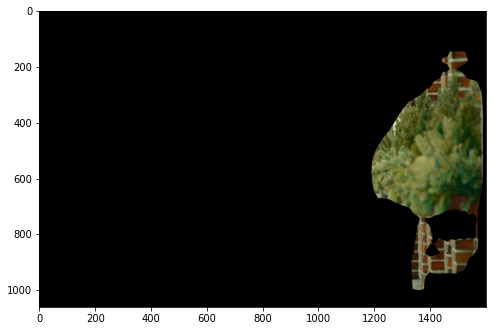

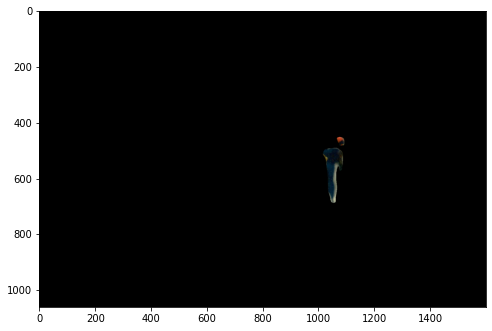

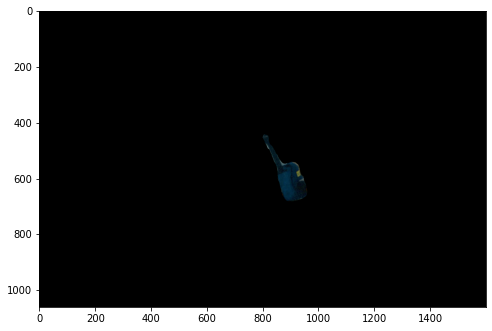

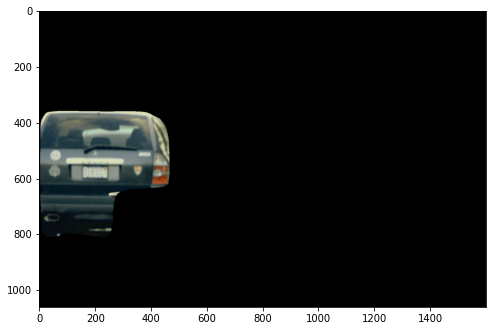

In [28]:
for i in range(mask.shape[2]):
    temp = skimage.io.imread(
        '/content/drive/My Drive/Colab Notebooks/Mask_RCNN/my_images/frank-zhang-7q03XfDSKQo-unsplash.jpg')
    for j in range(temp.shape[2]):
        temp[:,:,j] = temp[:,:,j] * mask[:,:,i]
    plt.figure(figsize=(8,8))
    plt.imshow(temp)